# Approximating Exponential Function by Composition of Polynomials

In [1]:
import numpy as np
from math import factorial
from numpy.linalg import norm, matrix_power
from scipy.linalg import expm
import time
from scipy.interpolate import pade
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interactive

### 1. Scaling and Squaring Method (SSM)

The way SSM works is my exploiting the special property of exponential functions:
\begin{equation*}
    e^A = (e^{A/\sigma})^{\sigma} 
\end{equation*}where $\sigma\in\mathbb{R}$ is typically taken to be power of two, i.e. $\sigma = 2^s$ and $s\in\mathbb{N}$ is known as the *scaling* parameter. Then $\text{exp}(A/2^s)^{2^s}$, can be computed reliably and accurately by repeated squaring: 
\begin{equation}
    e^A = \left(e^{A/2^s}\right)^{2^s} = \underbrace{\left(\dots\Big(e^{A/2^s}\Big)^{2^{\LARGE{\dots}}}\right)^{2}}_{s-times} = \underbrace{q\Big(q\Big(\dots q}_{s-times} \Big(e^{A/2^s}\Big)\Big)\Big)  
\end{equation}
where function $q(A) = A^2$ for a given matrix (same holds for scalar). The $\text{exp}(A/2^s)$ is usually replaced by a polynomial approximation for example the $m^{th}$-degree Taylor expansion $T_m(A/2^s)\in \mathcal{P}_m$ or by the rational approximations typically, the $[k/m]$-order Pade Approximation.
\begin{equation}
T_m(A/2^s) = \sum_{k=0}^m \frac{A^k}{2^{sk}k!}
\end{equation}
\begin{equation}
e^A \approx\Big(T_m(A/2^s) \Big)^{2^s} = \underbrace{q\Big(q\Big(\dots q}_{s-times} \Big(T_m(A/2^s)\Big)\Big)\Big)  
\end{equation}

* __Degrees__ of a __Composite Taylor Polynomial__: $deg(T_m(A)) = 2^s m $
* __Degrees of Freedom__: $(m+1)+3s$
* __Complexity__ of the algorithm: $O\left((m+s)n^3\right)$

### 2. Why not just use *plain* Taylor

Plain Taylor is just to *approximate* exponential function by first $m+1$ terms of its Taylor expansion. Basically __Truncating__ the series. 
\begin{equation*}
    \text{exp}(A) \approx T_m(A) = \sum_{k=0}^{m} \frac{A^k}{k!}
\end{equation*}
We find $m$ such that $fl[T_m(A)] = fl[T_{m+1}(A)]$. This might seem like a perfectly valid way of approximating exponential function but due to __floating point arithmetic__, we get a pretty poor approximation even in the scalar case. This kind of approximation is terrible which we will show by an example.  

Floating point representation of $x\in\mathbb{R}$ is: 
$$fl(x) = x(1+\varepsilon) \quad \quad \quad |\varepsilon| \leq \epsilon_{mach} \approx 1\times 10^{-16}$$

We will consider an example where $\textbf{z = -40}$ and we choose an $m$ such that $fl[T_m(A)] = fl[T_{m+1}(A)]$. Here ofcourse our scaling parameter $s = 0$. 

[40]


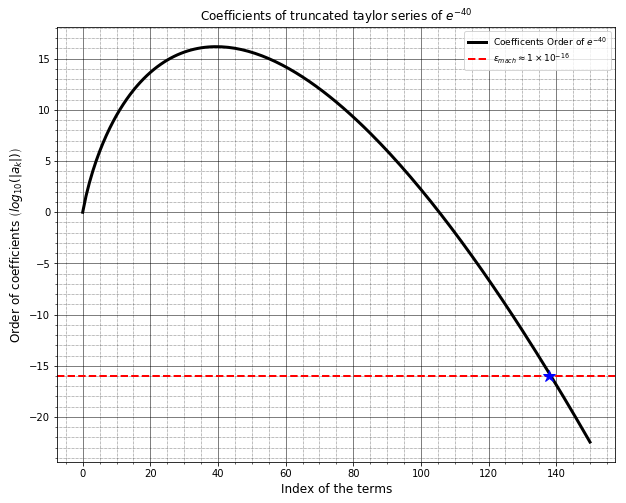

Value of m when we have machine precision = 138

Approximation: -9.818572998046875
Actual Value: 4.248354255291589e-18
Error: 2.311147425104023e+18


In [7]:
m = 150
x =  -40
s = 0

f_m = list(map(lambda j: (x**j/(2**(j*s)*factorial(j)))**(2**s),range(0,m+1)))
approx = f_m = list(map(lambda j: (x**j/(2**(j*s)*factorial(j))),range(0,m+1)))
print([np.argmax(f_m)])

if s == 0:
    plt.figure(figsize = (10,8))
    plt.plot(range(0,m+1),np.log10(np.abs(f_m)),'-k',lw=3,label = r'Coefficents Order of $e^{-40}$');
    plt.axhline(y=np.log10(np.spacing(1)/2),xmin=0,ls='--',color = 'r',lw=2, label = r'$\epsilon_{mach}\approx 1\times 10^{-16}$')
    plt.plot([138],[np.log10(np.spacing(1)/2)],'b*',markersize=12)
    maxi = int(x)/2**s
    plt.minorticks_on()
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='k')
    plt.xlabel('Index of the terms',fontsize = 12)
    plt.ylabel(r"Order of coefficients $\left({log}_{10}(|a_k|)\right)$",fontsize = 12)
    plt.title(r'Coefficients of truncated taylor series of $e^{-40}$')
    plt.legend(loc=1,prop={'size': 9})
    plt.show()

print(f'Value of m when we have machine precision = {138}\n')
print(f'Approximation: {np.sum(approx)**(2**s)}')
print(f'Actual Value: {np.exp(x)}')
error = abs(np.sum(approx)**(2**s)-np.exp(x))/abs(np.exp(x))
print(f'Error: {error}')
#print(f'Digits of accuracy: {round(np.log10(error))} digits')


We find that the value of $m$ where we see the *magnitude* of the coefficients of plain Taylor drop below $10^{-16}$ is $\bf{m = 138}$. 

The computed value not only has a wrong sign but also is off by order of $10^{17}$. In particular, if you consider the terms $\frac{z^{39}}{39!}$ and $\frac{z^{40}}{40!}$ who have the value $-1.4816805..\times 10^{16}$, $1.4816805..\times 10^{16}$ respectively. i.e same magnitude but different signs; and we expected them to cancel each other out. But since the absolute error is larger than the relative accuracy (since machine precision is only accurate to 16 digits), we get *catastrophic cancellation* giving us terrible floating point arithmetic.

Same can be shown for matrix case $A\in \mathbb{C}^{n\times n}$ which is highlighted in the paper *Nineteen Dubious Way Paper* where Moler and Loan consider the matrix 
\begin{equation}\label{ex: matrix}
    A = \left[\begin{array}{cc}
-49 & 24 \\
-64 & 31   \\
\end{array}\right] 
\end{equation}and show that under machine precision of $\epsilon_{mach}\approx 1\times 10^{-6}$ and truncation parameter of $m=59$, we have our approximation and exact value as follows: 
\begin{equation*}
    T_m(A) = \left[\begin{array}{cc}
-22.25880 & -1.432766 \\
-61.499931 & -3.474280   \\
\end{array}\right]  \hspace{1cm} \text{exp}(A) = \left[\begin{array}{cc}
-0.735759 & 0.551819 \\
-1.471518 & 1.103638   \\
\end{array}\right]
\end{equation*} which are again poor approximation of $e^A$. 

But if you now apply the same approximation using __Scaling and Squaring Method__

In [7]:
def taylor_exp(A, tol = 1e-8, p = 2): 
    
    start = time.perf_counter()
    n = len(A)
    print(f'Dim of A n: {n}\n')
    print(f'The Matrix A:\n{A}\n')
    
    norm_A = norm(A,ord = p) #2 norm

#     s = 0
    s = int(np.ceil(np.log2(norm_A)+1))  # by solving ||A||/2^s < 1
    print(f'The value of squaring size s: {s}\n')

    #B = A/2**s

    k = 0
    M0 = np.eye(n)  #identity matrix 

    #for i in range(1,m):
    while norm(matrix_power(A,k),ord = p)/(2**(s*k)*factorial(k)) > tol:
        #print(norm(matrix_power(B,k),ord = p)/factorial(k))
        #print(*M0)
        #print(matrix_power(B,k)/factorial(k))
        k+=1
        M0 = np.add(M0,matrix_power(A,k)/(2**(s*k)*factorial(k)))
        
        

    end = time.perf_counter()    
    print('DONE')
    print(f'We truncated our Taylor Series to m = {k-1} terms where m(tol)\n') #by the code we add calculate dimension of T_m not degree

    M = matrix_power(M0,2**s)
    exact_M = expm(A)

    print(f'Actual e^A using expm function:\n{exact_M}\n')
    print(f'Estimation :\n{M}\n')
    
    error = norm(M-exact_M,ord=p)/(norm(exact_M,ord = p))
    
    print(f'Relative Forward Error: {error}')
    print(f'Correct to: {-round(np.log10(error))} digits') #if we have negative val then its accurate to that many digits
    print(f'Time required for computation: {end-start} seconds')
    print('===============================================================')
    
    return error,M,s,k  #here my m = k

if __name__ == '__main__':
    n = 2
    m = 30
    tol = 1e-9
    A = np.array([[-49.0,24.0],[-64.0,31.0]])
    
    norm_A = norm(A,ord = 2) #2 norm
    #print(tol*norm_A*np.exp(tol*norm_A))
    taylor_exp(A,tol = tol, p=2)
    

Dim of A n: 2

The Matrix A:
[[-49.  24.]
 [-64.  31.]]

The value of squaring size s: 8

DONE
We truncated our Taylor Series to m = 5 terms where m(tol)

Actual e^A using expm function:
[[-0.73575876  0.5518191 ]
 [-1.4715176   1.10363824]]

Estimation :
[[-0.73575876  0.5518191 ]
 [-1.4715176   1.10363824]]

Relative Forward Error: 9.551172554861411e-14
Correct to: 13.0 digits
Time required for computation: 0.0010080949869006872 seconds


__The difficulty we are observing is not with truncating the Taylor series, but in-fact it is with truncating the floating point version of Taylor series i.e $fl[T_m(A)]$__.
This is very *important*. Since we are stuck with __finite memory__ and thus a fixed machine precision, all we can do is purposely _scale_ the matrix (or absolute value of a scalar $z$) so that $\|A\|$ is closer to zero (so we have accuracy to more decimal places) and then compute the truncated Taylor series of that; which is re-scaled back up again. This is precisely the intuition Scaling and Squaring Method. 

### 3. Rounding Errors


#### Absolute Rounding Error:

\begin{equation}
\left|fl[T_m(x)] - T_m(x)\right| \leq 2m\epsilon_{mach}e^{|x|}
\end{equation}

#### Relative Rounding Error:
\begin{equation}
    \frac{\left|fl[T_m(x)] - T_m(x)\right|}{|T_m(x)|} \leq  \begin{cases}
        2m\epsilon_{mach}       \quad \text{if } x\geq 0\\
        2m\epsilon_{mach}e^{2|x|}   \quad \text{if } x<0
     \end{cases}
\end{equation}

#### Complex: 
\begin{equation}
    \frac{\left|fl[T_m(z)] - T_m(z)\right|}{|T_m(z)|}\leq 2m\epsilon_{mach}e^{|z|-\text{Re}(z)}
\end{equation}

This shows that the representation is worst off if $x<0$ or if $Re(z) < 0$.

### 4. Truncation Error for Matrix case:

$$\frac{\left\|\left[T_m\left(\frac{A}{2^s}\right)\right]^{2^s} - e^A\right\|}{\|e^A\|} \leq \epsilon_{mach}\|A\|e^{\epsilon_{mach}\|A\|}$$

### 4. Analysis of SSM using Contour plots

Suppose matrix $A\in\mathbb{C}^{n\times n}$ is a *diagonalizable* matrix, then its eigenvalue decomposition can be written as: 
\begin{equation*}
    A = X\text{diag}(\lambda_i)X^{-1} \quad \quad  \lambda_i\in \sigma(A), \quad i=1,\dots,n 
\end{equation*}
Then we can express \begin{equation*}
    e^A = X\text{diag}(e^{\lambda_i})X^{-1}
\end{equation*} and its composite Taylor approximation  
\begin{equation*}
    Y = X\text{diag}\left(\left[T_m({\lambda_i/2^s})\right]^{2^s}\right)X^{-1} \quad\quad T_m\in\mathcal{P}_m
\end{equation*}
Then if we measure the absolute error under $2$-norm we get that:

\begin{equation}\label{eqn:abs_error}
    \|e^A-Y\|_2 \leq \kappa(X) \ \underset{z\in\mathcal{D}}{\max}\left|e^{z} - \left[T_m\left({z/2^s}\right)\right]^{2^s}\right|
\end{equation} where $\mathcal{D}$ is the region in the complex plane that contains all the eigenvalues of $A$ $\ \left(\lambda_i\in \mathcal{D}\right)$ and $\kappa(X) = \|X\|_2\|X^{-1}\|_2$ is known as the *condition number* of the eigenvector matrix $X$. We will assume that $X$ is well-conditioned and $\kappa(X)$ is sufficiently small so that it doesn't deteriorate the bound. When matrix $A$ is normal, $X$ becomes __unitary__ and the term $\underset{i=1:n}{\max}\left|e^{\lambda_i} - \left[T_m\left({\lambda_i/2^s}\right)\right]^{2^s}\right|$ represents the exact absolute error. 
\begin{equation}
    \|e^A-Y\|_2 \leq \ \underset{z\in\mathcal{D}}{\max}\left|e^{z} - \left[T_m\left({z/2^s}\right)\right]^{2^s}\right|
\end{equation} 

#### Contour Plots

We set the region $\mathcal{D} = \big\{z\in\mathbb{C}: Re(z),Im(z)\in[-60,60]\big\}$ and measure both absolute and relative error i.e.:
\begin{equation*}
    \left|e^z - \left[T_m(z/2^s)\right]^{2^s}\right|\hspace{3cm} \frac{\left|e^z - \left[T_m(z/2^s)\right]^{2^s}\right|}{|e^z|}
    \end{equation*}
    
We measure both the __absolute error__ and __relative error__ and look for __regions__ where we have the best approximation for different values of $z\in\mathcal{D}$. 

In [27]:
def experiment_taylor(s=3, m=18 , n = 400, a = -60, b = 60):
    
    def approx_taylor_exp(x,m):
        f_m = list(map(lambda x: 1/factorial(x),range(0,m+1)))
        f_m.reverse()
        p = np.poly1d(f_m)
        return p(x)
    
    def segment(m,s):
        r = (10**(-2**(4-s))*(2**(s*(m+1))*factorial(m+1)))**(1/(m+1))
        print(r)
        re_z_high = np.log(10**(-16))
        return r, re_z_high

    xgrid = np.linspace(a,b,n+1)
    X,Y = np.meshgrid(xgrid,xgrid)
    Z = X+1j*Y
    #print(Z[50,:][8])
    r,re_z_high = segment(m,s)
    Z_circle = Z[np.sqrt(X**2+Y**2) < r]
    Z_circle = Z_circle[np.real(Z_circle) < re_z_high]
    #print(Z_circle)
    

    T_m = approx_taylor_exp(Z/2**s,m)**(2**s)
    exact_M = np.exp(Z)  
    eps = 0.5*np.spacing(1)  #machine precision
    
    rel_Error = np.log10((abs(exact_M - T_m)/abs(exact_M)) + eps)
    abs_Error = np.log10(abs(exact_M - T_m) + eps)
    
    #print(10**(rel_Error[50,:][8]))
    #print(10**(abs_Error[50,:][8]))
    
    max_rel_error_ind = np.where(rel_Error == rel_Error.max())
    min_rel_error_ind = np.argmin(rel_Error)  #flattens the matrix and then gives an index
    rel_i,rel_j = min_rel_error_ind//(n+1), min_rel_error_ind%(n+1)
    
    max_abs_error_ind = np.where(abs_Error == abs_Error.max())
    min_abs_error_ind = np.argmin(abs_Error)  #flattens the matrix and then gives an index
    abs_i,abs_j = min_abs_error_ind//(n+1), min_abs_error_ind%(n+1)
        
    ax = plt.figure(figsize = (17,7))
    
    ax = plt.subplot(1, 2, 2)
    plt.contour(X,Y,rel_Error, levels = np.arange(-16,18,2),colors='black', linewidths=0.5);
    CS = plt.contourf(X,Y,rel_Error, levels = np.arange(-16,18,2));
    #plt.contour(X,Y,rel_Error,colors='black', linewidths=0.5,levels = 8);
    #CS = plt.contourf(X,Y,rel_Error, levels = 8);
    rel_real, rel_imag = Z[rel_i,rel_j].real, Z[rel_i,rel_j].imag 
    rel_real_max, rel_imag_max = Z[max_rel_error_ind].real, Z[max_rel_error_ind].imag 
    plt.plot(rel_real,rel_imag,'rx',markersize = 10,label=f'min $z$');
    plt.plot(rel_real_max,rel_imag_max,'kD',markersize = 7,label='max $z$'); plt.legend();
    plt.colorbar(CS,orientation = 'horizontal',pad = 0.07).ax.tick_params(labelsize=13);
    plt.title(f'Relative Error for $T_m$   (s: {s}, m: {m})',fontsize = 22)
    padding = 2.4
    plt.tick_params(labelsize=14);
    plt.xticks(np.arange(a, b+1, 10))
    plt.yticks(np.arange(a, b+1, 10))
    plt.xlim(a-padding,b+padding)
    plt.ylim(a-padding,b+padding)
    plt.legend(prop={'size': 15})
    plt.tight_layout()
    #plt.savefig(f'plots/contourplots/rel_m_{m}_s_{s}.png', format='png', dpi=1200)
    #plt.show()
    
    #ax = plt.figure(figsize = (8.5,7))
    #ax = plt.subplot(1, 2, 2,facecolor = (230/255, 237/255, 12/255))
    ax = plt.subplot(1, 2, 1)
    plt.contour(X,Y,abs_Error, levels = np.arange(-16,1,1),colors='black', linewidths=0.5);
    CS2 = plt.contourf(X,Y,abs_Error, levels = np.arange(-16,1,1));
    #plt.contour(X,Y,abs_Error,colors='black', linewidths=0.5);
    #CS2 = plt.contourf(X,Y,abs_Error);
    abs_real, abs_imag = Z[abs_i,abs_j].real, Z[abs_i,abs_j].imag 
    abs_real_max, abs_imag_max = Z[max_abs_error_ind].real, Z[max_abs_error_ind].imag 
    plt.plot(abs_real,abs_imag,'rx',markersize = 10,label=f'min $z$');
    plt.plot(abs_real_max,abs_imag_max,'kD',markersize = 7,label=f'max $z$'); plt.legend();
    plt.colorbar(CS2, orientation = 'horizontal',pad = 0.07).ax.tick_params(labelsize=13);
    Z_circle = np.absolute(Z)
    #plt.axvline(x= - r ,ls='--',color = 'r',lw=2)
    #plt.axvline(x= re_z_high,ls='--',color = 'y',lw=2)
    #circ = plt.Circle((0, 0), radius=r, color='m',fill=False,linestyle = '--',linewidth =  3)
    #ax.add_patch(circ)
    
    #seg_x = np.array(list(filter(lambda val: abs(val) < r and np.real(val) < re_z_high, Z.reshape(-1))))
    #real,imag = seg_x.real, seg_x.imag 
    #plt.fill(real,imag,color = 'r')
    #plt.fill(seg_x,-seg_y)
    
    #plt.fill_between(Z, abs_Error, Z_circle.reshape(-1), where=Z_circle.reshape(-1)<=112, facecolor='gold')
    plt.title(f'Absolute Error for $T_m$   (s: {s}, m: {m})',fontsize = 22)
    
    plt.xlim(a-padding,b+padding)
    plt.ylim(a-padding,b+padding)
    plt.xticks(np.arange(a, b+1, 10))
    plt.yticks(np.arange(a, b+1, 10))
    plt.tick_params(labelsize=14);
    plt.legend(prop={'size': 15})
    plt.tight_layout()
    #plt.savefig(f'plots/contourplots/abs_m_{m}_s_{s}.png', format='png', dpi=1200)
    #plt.autoscale(axis='x')
    plt.show()
    
    print('Relative Error Analysis\n=======================')
    print(f"Largest error z_jk:{[z for z in Z[max_rel_error_ind]]}")
    print(f'Maximum Error Order: {np.max(rel_Error)}\n')
    print(f"Smallest error z_jk: {Z[rel_i,rel_j]}")
    print(f'Minimum Error Order: {np.min(rel_Error)}\n')
    
    print('Absolute Error Analysis\n=======================')
    print(f"Largest error z_jk:{[z for z in Z[max_abs_error_ind]]}")
    print(f'Maximum Error Order: {np.max(abs_Error)}\n')
    print(f"Smallest error z_jk: {Z[abs_i,abs_j]}")
    print(f'Minimum Error Order: {np.min(abs_Error)}\n')
    print('=====================================================================================================================')
    #print(f'Complex Lattice:\n{Z}\n')
    #print(f'Relative Error at each z_jk:\n{(abs(exact_M - T_m)/abs(exact_M))}\n')
    #print(f'log_10(rel error):\n{rel_Error}\n')

#experiment_taylor(s = 4, m= 8, a = -100, b = 100, n = 100)
interactive_plot = interactive(experiment_taylor, s=(0, 10),m=(0, 50), n=(0,1000,10),a = (-300,0,10), b = (0, 300,10))
interactive_plot


interactive(children=(IntSlider(value=3, description='s', max=10), IntSlider(value=18, description='m', max=50…

### 5. Best approximation region (to the order $10^{-16})$ in __Absolute terms__


Let $z\in\mathbb{C}$ and let plain truncated Taylor series $T_m\in\mathcal{P}_m$ of $e^z$ centered at zero by defined by $T_m(z) = \sum_{k=0}^{m} \frac{z^k}{k!}$, then the absolute truncation error is given by: 
\begin{equation}\label{eqn:identity}
    \left|e^z - T_m(z)\right| \leq \frac{|z|^{m+1}}{(m+1)!}max\{1,e^{Re(z)}\}
\end{equation}

This can be shown by making use of *Cauchy Integral Formula*. 

So in order to find this region theoretically, we need to consider two things: 
1. $|e^z| = O(10^{-16}) \text{  if   } Re(z) < ln(10^{-16}) \approx -36.8$. This is noting the fact that $|e^z| = e^{Re(z)}$
2. Then if we choose a $z$ such that $Re(z) < ln(10^{-16})$, then in __floating point arithemtic__, 
$$|e^z - T_m(z)| \leq |e^z| + |T_m(z)| \approx |T_m(z)|$$ 

In the scaling and squaring method, we are interested in calculating the absolute error of $\left|e^z - \left[T_m(z/2^s)\right]^{2^s}\right|$. Since we choose $z\in\mathbb{C}$ such that $Re(z) < \text{ln}(10^{-16})$, then in floating point arithmetic it can be shown: 
\begin{align*}
    \left|e^z - \left[T_m(z/2^s)\right]^{2^s}\right| \approx \left[T_m(z/2^s)\right]^{2^s}\leq \left[\frac{|z|^{m+1}}{2^{s(m+1)}(m+1)!}\right]^{2^s}
\end{align*}

So in order to have the absolute error $\left|e^z - \left[T_m(z/2^s)\right]^{2^s}\right| = O(10^{-16})$, it suffices to find $z\in\mathbb{C}$ such that:
\begin{align*}
    &\left[\frac{|z|^{m+1}}{2^{s(m+1)}(m+1)!}\right]^{2^s} < O(10^{-16}) \quad \text{and} \quad Re(z) < \text{ln}(10^{-16}) \\
    &\iff 
    \end{align*}
    \begin{align}
        \hspace{2.5cm} |z| < \left[\left(10^{-16}\right)^{2^{-s}}\times 2^{s(m+1)}(m+1)!\right]^{\frac{1}{m+1}} = r_{s,m} \quad \text{and} \quad Re(z) < \text{ln}(10^{-16})
    \end{align}
So the region in $\mathbb{C}$ where we have the approximation to the order of $10^{-16}$ of $e^z$ by composite Taylor series in absolute terms is: 
$$\mathcal{R} = \left\{z\in\mathbb{C} : |z| < r_{s,m} \quad \text{and} \quad Re(z) < \text{ln}(10^{-16})\right\}$$
where the region $\mathcal{R}$ represents a __circular segment__ in complex plane. 

In [29]:
def experiment_taylor(s=3, m=18 , n = 400):
    
    def approx_taylor_exp(x,m):
        f_m = list(map(lambda x: 1/factorial(x),range(0,m+1)))
        f_m.reverse()
        p = np.poly1d(f_m)
        return p(x)
    
    def segment(m,s):
        eps = 0.5*np.spacing(1)
        r = ((eps**(2**(-s)))*(2**(s*(m+1))*factorial(m+1)))**(1/(m+1))
        print(r)
        re_z_high = np.log(10**(-16))
        return r, re_z_high

    r,re_z_high = segment(m,s)
    r,re_z_high = int(round(r)), int(round(re_z_high))
    
    gap = r*0.1
    a = int(-r-gap)
    b = int(r+gap)
    
    xgrid = np.linspace(a,b,n+1)
    X,Y = np.meshgrid(xgrid,xgrid)
    Z = X+1j*Y
    
    
    T_m = approx_taylor_exp(Z/2**s,m)**(2**s)
    exact_M = np.exp(Z)  
    eps = np.spacing(1)  #machine precision
    
    rel_Error = np.log10((abs(exact_M - T_m)/abs(exact_M)) + eps)
    abs_Error = np.log10(abs(exact_M - T_m) + eps)

    plt.figure(figsize = (8.5,7))

    ax = plt.subplot(1, 1, 1)
    plt.contour(X,Y,abs_Error, levels = np.arange(-16,1,1),colors='black', linewidths=0.5);
    CS2 = plt.contourf(X,Y,abs_Error, levels = np.arange(-16,1,1));
    plt.colorbar(CS2, orientation = 'horizontal',pad = 0.07).ax.tick_params(labelsize=13);
    
    plt.axvline(x= -r ,ls='--',color = 'r',lw=3)
    plt.axvline(x= re_z_high,ls='--',color = 'y',lw=3)
    
    # creating the segment
    seg_x = np.array(list(filter(lambda val: abs(val) < r and np.real(val) < re_z_high, Z.reshape(-1))))
    real,imag = seg_x.real, seg_x.imag 
    
    plt.fill(real,imag,color = 'r', alpha = 0.4,hatch='x')
    
    circ = plt.Circle((0, 0), radius=r, color='k',fill=False,linestyle = '--',linewidth =  3)
    ax.add_patch(circ)
    
    plt.title(f'Absolute Error for $T_m$   (s: {s}, m: {m})',fontsize = 22)
    
    plt.xlim(a,b)
    plt.ylim(a,b)
    plt.xticks(np.arange(a, b+1, 10))
    plt.yticks(np.arange(a, b+1, 10))
    #plt.tick_params(labelsize=14,);
    plt.tick_params(labelsize=14)
    ax.tick_params(axis='x', colors='k')
    ax.set_yticks([])
    ax.set_xticks([-r,re_z_high])
    plt.tight_layout()
    plt.show()
    
    

#experiment_taylor(s=5 ,m=20 , n = 400)
interactive_plot = interactive(experiment_taylor, s=(0, 10),m=(0, 100), n=(0,1000,10))
interactive_plot


interactive(children=(IntSlider(value=3, description='s', max=10), IntSlider(value=18, description='m'), IntSl…

 The region $\mathcal{R}$ which we have determined in the section is a key result. It brings together two types of errors (in absolute sense) which we observe when we approximate $e^z$ by the composite Taylor: 

1. __Truncation error__: the error occurs because in scaling and squaring method, we are approximating $e^z$ by $2^sm$ degree polynomial. 
2. __Rounding error__: since we have only finite memory, the floating point representation of $z$ i.e. $fl(z)$, can have a roundoff error as large as $10^{-16}$ and we can only represent a number to $15$ digits of accuracy. 


### 5. Extra Numerical Results

In this section, we consider how __maximum error__ (both in _absolute_ and _relative terms_) between $\exp(z)$ and $\left[T_m(z/2^s)\right]^{2^s}$ is effected with respect to: 
* __degree__ of the composite Taylor polynomial
* __degrees of freedom__ (DoF) 

#### Algorithm for the plots below
1. Initialisation: Pick a radius $R>0$; pick $n,s\in\mathbb{N}$ and finally choose the maximum value of truncation parameter $m_{max}$\;
2. Randomly generate $n$ complex numbers $z\in\mathbb{C}$ such that $|z| = R$ and call this set $\mathcal{T}. \quad \left(\text{this set is defined as } \mathcal{T} = \left\{z_i\in\mathbb{C}: |z_i| = R \ , \ i=1,\dots,n\right\}\right)$\;

For $m$ in $1,\dots,m_{max}$\;
3. Calculate the composite Taylor $\left[T_m(z/2^s)\right]^{2^s} = \left[\sum_{k=0}^{m}\frac{z^k}{2^{sk}k!}\right]^{2^s}$\;
4. Calculate the maximum error in absolute or relative terms for each $m$\; 
$M_{m} = \max \left\{\left|e^z - \left[T_m(z/2^s)\right]^{2^s}\right| : z\in\mathcal{T}\right\}\quad \text{OR}$  $\quad M_{m} = \max \left\{ \frac{\left|e^z -\left[T_m(z/2^s)\right]^{2^s}\right|}{|e^z|} : z\in\mathcal{T}\right\}$\;
5. Store all the maximum errors in $\mathcal{M} = \left\{M_m : m = 1,\dots,m_{max}\right\}$\;

Plot the graph of $\log_{10}\mathcal{M} = \left\{\log_{10}M_m : m = 1,\dots,m_{max}\right\}$ against the degree of the composite polynomial which is $2^sm$ OR against the degrees of freedom which is $(m+1)+3s$ for each $m = 1,\dots,m_{max}$\;

We choose our __$R = 20$ and $n = 500$__

1.For __Absolute Error__, the maximum error occurs for $R=20$ is at $z=20$: 
 - $exp(20) = O(10^8)$ and we only have $15$ digits of accuracy. So the solution is only accurate to $\lfloor16-\log_{10}(e^{20})\rfloor$ many digits which is roughly $7$ digits. This is why we start to see the line flatten in the absolute error graphs. 
 
2.For __Relative Error__, we expect the maximum error to occur for $R=20$ at $z= -20$. 

We will explain the peak in the relative error graph by the following example: 
 - I showed in the appendix B that the value of truncation parameter $m$ at which peak occurs happens when $m =|z|/2^s = R/2^s$
 - But since the plot is wrt to degree, I just multiple $m$ by $2^s$. So degree of composite polynomial at which we have max relative error is in fact just integer of $R$.   

So the example I used was $R = 20$ and $s = 2$. So since $m = 20/2^2 = 5$ and max relative error is at $z = -20$. 
Since relative error is: 
$$\frac{\left|e^z - \left[T_m(z/2^s)\right]^{2^s}\right|}{|e^z|}$$
So the numerator of the relative error:
$$\frac{(-20)^5}{5!} = O(10^4)$$
and the denominator has the order: $$e^{(-20)} = O(10^{-9})$$
Since you are dividing, so overall order of the maximum relative error is obviously $10^4/ 10^{-9} = 10^{13}$. This is why for this particular example, I got this order at the peak. 